In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings

# ARIMA Forecasting

In [2]:
df_arima = pd.read_csv('data4.csv', encoding='ISO-8859-1')
df_arima.head()

,Name,Present,Previous,CU.M.,Amount,Area_Number,Date,Initial
0,"Abainza, Jouie",1056,1051,5,130,1,2020-Jan,130
1,"Adam, Eduardo",NaN,NaN,NaN,NaN,1,2020-Jan,130
2,"Adam, Evelyn II",2178,2164,52,834,1,2020-Jan,130
3,"Agosto, Juanario",4167,4140,27,434,1,2020-Jan,130
4,"Albano, Gina",NaN,NaN,NaN,NaN,1,2020-Jan,130


In [4]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      65011 non-null  int32 
 2   Previous     65011 non-null  int32 
 3   CU.M.        65011 non-null  int32 
 4   Amount       65011 non-null  int32 
 5   Area_Number  65011 non-null  int64 
 6   Date         65011 non-null  object
 7   Initial      65011 non-null  int64 
dtypes: int32(4), int64(2), object(2)
memory usage: 3.0+ MB


In [5]:
df_arima['Present'] = pd.to_numeric(df_arima['Present'], errors='coerce').fillna(0).astype(int)
df_arima['Previous'] = pd.to_numeric(df_arima['Previous'], errors='coerce').fillna(0).astype(int)
df_arima['CU.M.'] = pd.to_numeric(df_arima['CU.M.'], errors='coerce').fillna(0).astype(int)
df_arima['Amount'] = pd.to_numeric(df_arima['Amount'], errors='coerce').fillna(0).astype(int)

# Check the result
print(df_arima.dtypes)
print(df_arima.head())
df_arima.info()

Name           object
Present         int32
Previous        int32
CU.M.           int32
Amount          int32
Area_Number     int64
Date           object
Initial         int64
dtype: object
               Name  Present  Previous  CU.M.  Amount  Area_Number      Date  \
0    Abainza, Jouie     1056      1051      5     130            1  2020-Jan   
1     Adam, Eduardo        0         0      0       0            1  2020-Jan   
2   Adam, Evelyn II     2178      2164     52     834            1  2020-Jan   
3  Agosto, Juanario     4167      4140     27     434            1  2020-Jan   
4      Albano, Gina        0         0      0       0            1  2020-Jan   

   Initial  
0      130  
1      130  
2      130  
3      130  
4      130  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      65

In [6]:
# Convert the Date column to datetime format
df_arima['Date'] = pd.to_datetime(df_arima['Date'], format='%Y-%b')

# Convert non-numeric columns to numeric (for both Amount and CU.M.), coercing errors and replacing NaN with 0
df_arima['Amount'] = pd.to_numeric(df_arima['Amount'], errors='coerce').fillna(0)
df_arima['CU.M.'] = pd.to_numeric(df_arima['CU.M.'], errors='coerce').fillna(0)

# Group by the Date and sum both Amount and CU.M. columns
monthly_sum = df_arima.groupby(df_arima['Date'].dt.to_period('M'))[['Amount', 'CU.M.']].sum().reset_index()

# Convert 'Date' back to a string with only Month and Year
monthly_sum['Date'] = monthly_sum['Date'].dt.strftime('%Y-%b')

# Round the Amount and CU.M. columns to 2 decimal places
monthly_sum['Amount'] = monthly_sum['Amount'].round(2)
monthly_sum['CU.M.'] = monthly_sum['CU.M.'].round(2)

# Display the result
print(monthly_sum)

        Date  Amount  CU.M.
0   2020-Jan  391814  24106
1   2020-Feb  384230  23574
2   2020-Mar  446286  26434
3   2020-Apr  424098  25970
4   2020-May  447320  30497
5   2020-Jun  444322  27419
6   2020-Jul  428278  26376
7   2020-Aug  414622  25478
8   2020-Sep  413302  25371
9   2020-Oct  410570  25183
10  2020-Nov  393536  24076
11  2020-Dec  383500  23464
12  2021-Jan  397710  24329
13  2021-Feb  464870  23212
14  2021-Mar  527832  26836
15  2021-Apr  513570  26061
16  2021-May  572876  29439
17  2021-Jun  496962  25059
18  2021-Jul  494514  24994
19  2021-Aug  511808  26000
20  2021-Sep  479242  24098
21  2021-Oct  495200  24973
22  2021-Nov  481448  24245
23  2021-Dec  491672  24779
24  2022-Jan  487490  24546
25  2022-Feb  491780  24236
26  2022-Mar  507728  25734
27  2022-Apr  497378  25179
28  2022-May  524186  26777
29  2022-Jun  504590  25645
30  2022-Jul  516710  26301
31  2022-Aug  520412  26505
32  2022-Sep  501054  25377
33  2022-Oct  514356  26073
34  2022-Nov  522000

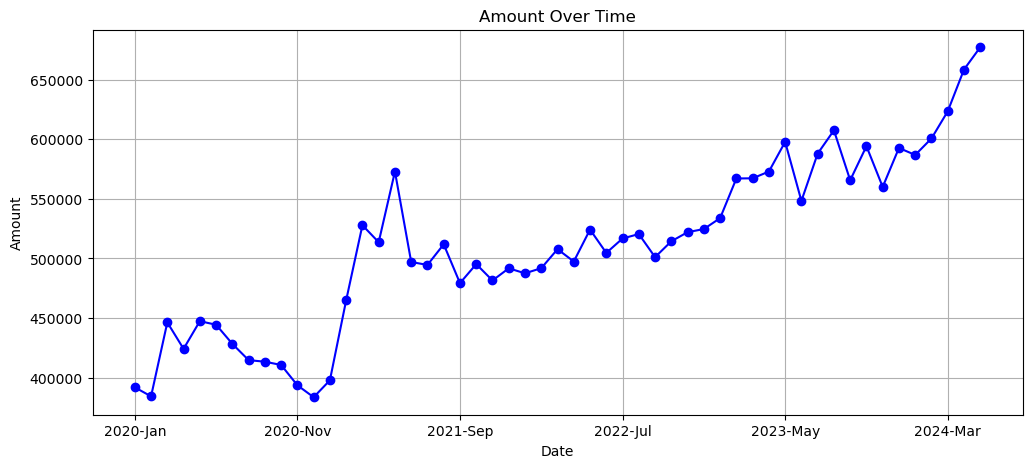

In [7]:
monthly_sum.set_index('Date', inplace=True)
# Plot the Amount column
monthly_sum['Amount'].plot(figsize=(12, 5), title="Amount Over Time", color='blue', marker='o')

# Add labels
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

# Checking if Stationary or Not (Differencing)

In [8]:
def check_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    
    if p_value < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity of the 'Amount' column
check_stationarity(monthly_sum['Amount'])

ADF Statistic: 0.05715794619263967
p-value: 0.9630113738712422
The time series is not stationary.


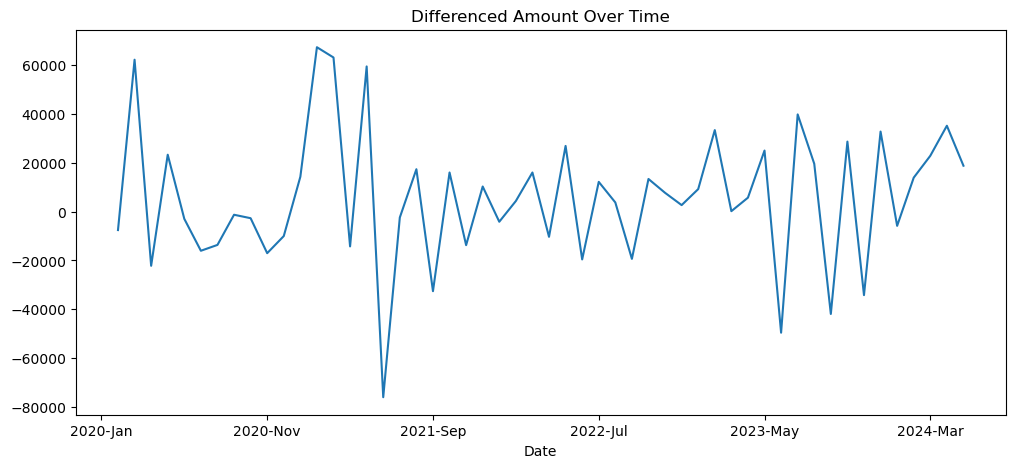

ADF Statistic: -4.130426510699647
p-value: 0.000862247317672007
The time series is stationary.


In [9]:
# Apply first-order differencing to the 'Amount' column
monthly_sum['Amount_diff'] = monthly_sum['Amount'].diff().dropna()

# Plot the differenced data to visually inspect stationarity
monthly_sum['Amount_diff'].plot(figsize=(12, 5), title="Differenced Amount Over Time")
plt.show()

check_stationarity(monthly_sum['Amount_diff'].dropna())

# Assessing what could be the best combination Before doing ARIMA

In [10]:
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    monthly_sum['Amount_diff'].dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1213.439, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1215.491, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1214.193, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1215.110, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1213.344, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1211.584, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1213.799, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1215.826, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1214.703, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1211.573, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1213.940, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1213.242, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1213.103, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1214.628, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept

# ARIMA Modeling

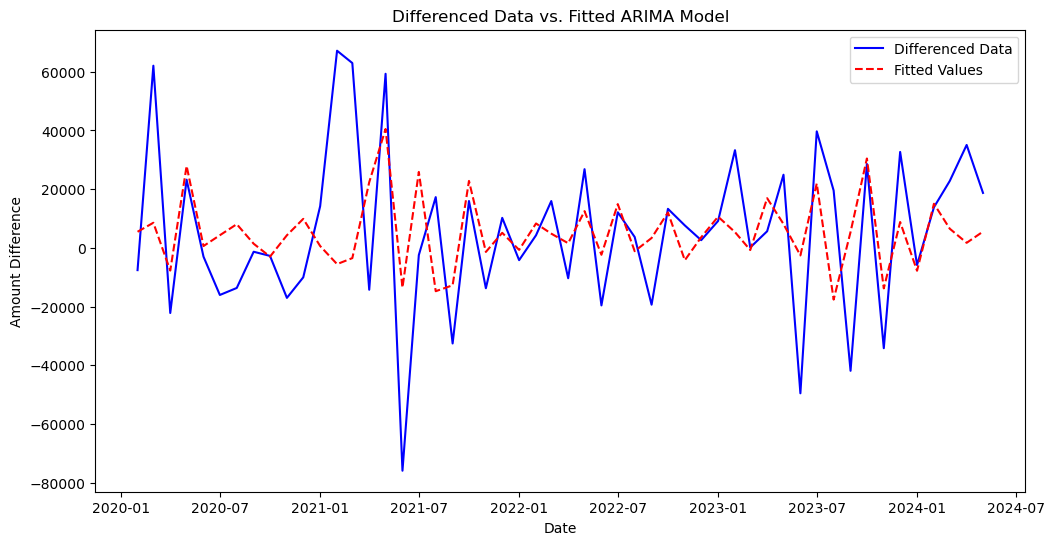

In [11]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(monthly_sum['Amount_diff'].dropna(), order=(0, 0, 2))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(monthly_sum['Amount_diff'], label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

# Checking of accuracy

In [12]:
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
train_size = int(len(monthly_sum) * 0.8)
train, test = monthly_sum.iloc[:train_size], monthly_sum.iloc[train_size:]

# Fit the ARIMA model on training data
model = ARIMA(train['Amount_diff'].dropna(), order=(0, 0, 2))
model_fit = model.fit()

# Forecast on test data
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)


In [13]:
mse = mean_squared_error(test['Amount_diff'].dropna(), forecast)
rmse = mse**0.5
mae = (abs(test['Amount_diff'].dropna() - forecast)).mean()

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


MSE: 968508785.812861
RMSE: 31120.873795779913
MAE: 26258.95314965568


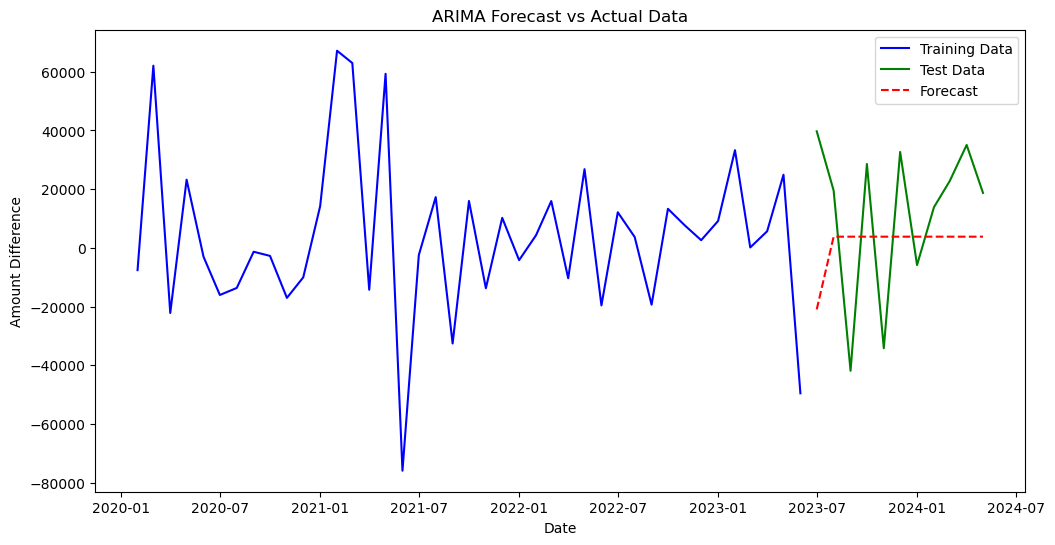

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Amount_diff'], label='Training Data', color='blue')
plt.plot(test.index, test['Amount_diff'], label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()
plt.show()

# Reverting back to original value

In [15]:
# Ensure index is in datetime format
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Reconstruct the original Amount from differenced data
# Start with the last known Amount
last_known_amount = monthly_sum['Amount'].iloc[0]

# Cumulatively sum the differences to get the forecasted Amount
monthly_sum['Reconstructed_Amount'] = last_known_amount + monthly_sum['Amount_diff'].cumsum()


In [16]:
# Fit the ARIMA model to the differenced data
model = ARIMA(monthly_sum['Amount_diff'].dropna(), order=(0, 0, 2))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

In [17]:
# Create a DataFrame for fitted values and convert to original scale
fitted_values_original = pd.Series(
    last_known_amount + fitted_values.cumsum(),
    index=monthly_sum.index[1:]  # Skip the first index which was used for initial amount
)

# Append NaN for the first index as it has no corresponding fitted value
fitted_values_original = pd.concat([pd.Series([last_known_amount], index=[monthly_sum.index[0]]), fitted_values_original])


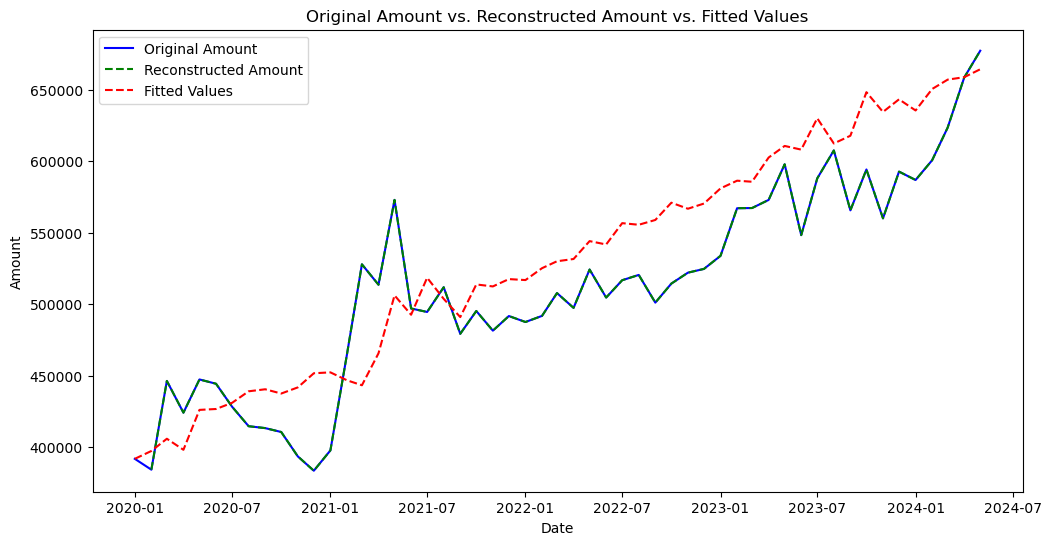

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the original Amount
plt.plot(monthly_sum['Amount'], label='Original Amount', color='blue')

# Plot the reconstructed Amount from differenced data
plt.plot(monthly_sum['Reconstructed_Amount'], label='Reconstructed Amount', color='green', linestyle='--')

# Plot the fitted values
plt.plot(fitted_values_original, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Original Amount vs. Reconstructed Amount vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()

# Show the plot
plt.show()


# Creating a forecast up to Dec 2025

In [19]:
import pandas as pd

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')


In [20]:
# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()


In [21]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['Amount'].iloc[-1]

# Reconstruct the forecasted amount
forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()


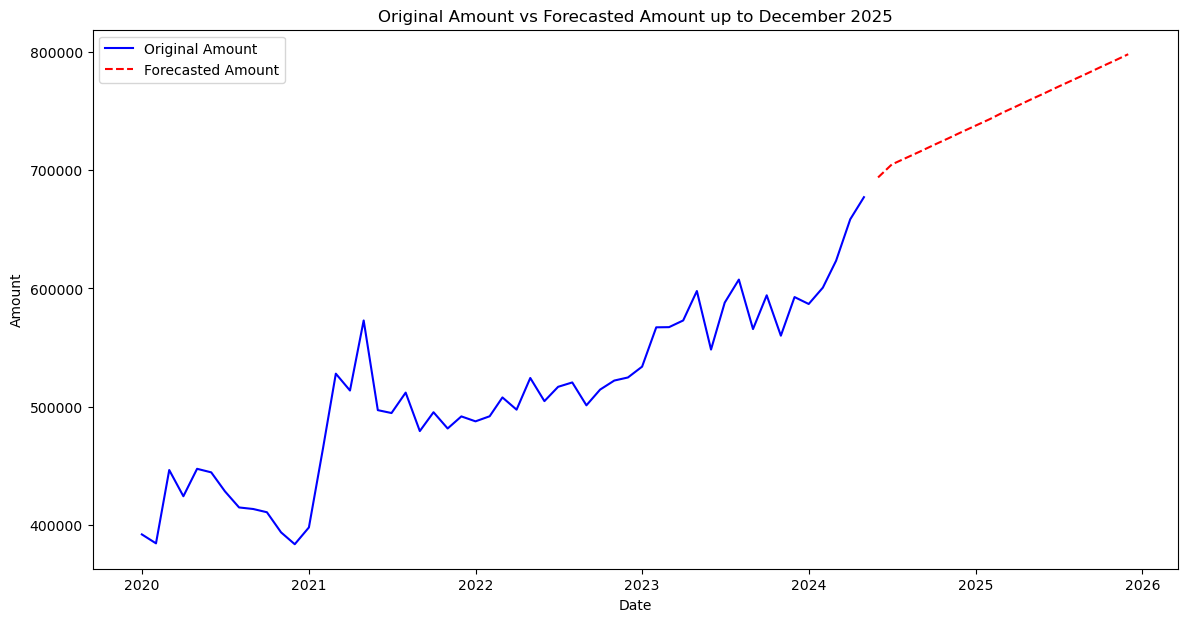

                 Forecast
2024-06-01  693902.315036
2024-07-01  704873.350590
2024-08-01  710361.542901
2024-09-01  715849.735212
2024-10-01  721337.927523
2024-11-01  726826.119835
2024-12-01  732314.312146
2025-01-01  737802.504457
2025-02-01  743290.696768
2025-03-01  748778.889079
2025-04-01  754267.081390
2025-05-01  759755.273702
2025-06-01  765243.466013
2025-07-01  770731.658324
2025-08-01  776219.850635
2025-09-01  781708.042946
2025-10-01  787196.235258
2025-11-01  792684.427569
2025-12-01  798172.619880


In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['Amount'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Ensure forecast_df has 'Forecast' column for printing
print(forecast_df[['Forecast']])


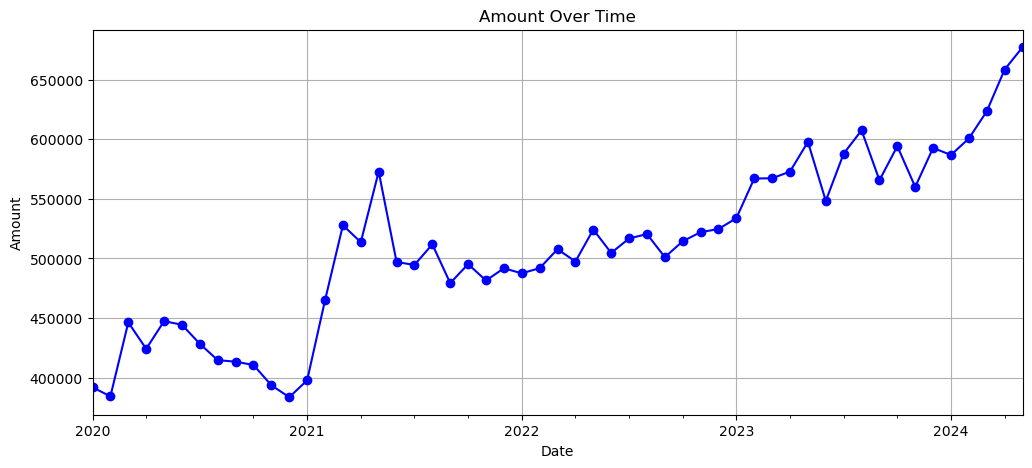

In [23]:
# Plot the Amount column
monthly_sum['Amount'].plot(figsize=(12, 5), title="Amount Over Time", color='blue', marker='o')

# Add labels
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [24]:
def check_stationarity2(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    
    if p_value < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity of the 'Amount' column
check_stationarity2(monthly_sum['Amount'])

ADF Statistic: 0.05715794619263967
p-value: 0.9630113738712422
The time series is not stationary.


# Seasonal Differencing

In [25]:
# Seasonal differencing, assuming monthly data with an annual seasonality (period=12)
seasonal_period = 12
seasonal_differenced = monthly_sum['Amount'] - monthly_sum['Amount'].shift(seasonal_period)
seasonal_differenced = seasonal_differenced.dropna()

# Check stationarity of the seasonally differenced data
check_stationarity2(seasonal_differenced)

ADF Statistic: -2.9072608826992776
p-value: 0.044510147291027924
The time series is stationary.


In [26]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit2 = auto_arima(
    seasonal_differenced.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=970.587, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1027.478, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=964.675, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1003.572, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=966.390, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=966.217, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=968.222, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=960.754, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=981.751, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=962.946, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=962.761, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=967.778, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=964.738, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.270 seconds
                               SA

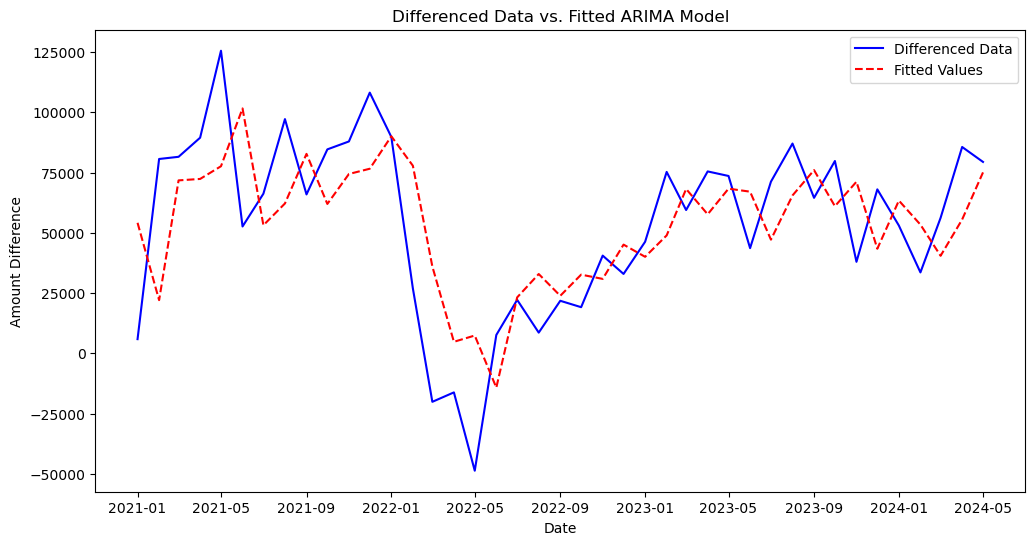

In [27]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(seasonal_differenced.dropna(), order=(1, 0, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(seasonal_differenced, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [28]:
# Align the fitted values with the original differenced data
aligned_index = seasonal_differenced.index.intersection(fitted_values.index)
fitted_values_aligned = fitted_values.loc[aligned_index]
differenced_data_aligned = seasonal_differenced.loc[aligned_index]

# Calculate residuals
residuals = differenced_data_aligned - fitted_values_aligned

# Compute MSE, RMSE, and MAE
mse = mean_squared_error(differenced_data_aligned, fitted_values_aligned)
rmse = np.sqrt(mse)
mae = mean_absolute_error(differenced_data_aligned, fitted_values_aligned)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 772085409.1429801
RMSE: 27786.424907551173
MAE: 22783.06057578736


# Log Transformation & Log Differenced

In [29]:
# Apply log transformation
log_transformed = np.log(monthly_sum['Amount'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0) issues
log_transformed = log_transformed.dropna()

# Check stationarity of the log-transformed data
check_stationarity2(log_transformed)

# Optionally, apply differencing after log transformation
log_differenced = log_transformed.diff().dropna()
check_stationarity2(log_differenced)


ADF Statistic: -0.3992385810142065
p-value: 0.9102258294685186
The time series is not stationary.
ADF Statistic: -4.4083588468702315
p-value: 0.00028688343995786667
The time series is stationary.


In [30]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit2 = auto_arima(
    log_differenced.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-149.936, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-150.084, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-149.544, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-149.387, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-148.480, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-146.085, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-151.012, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-149.796, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-149.781, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-149.311, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-150.317, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.588 seconds
                               S

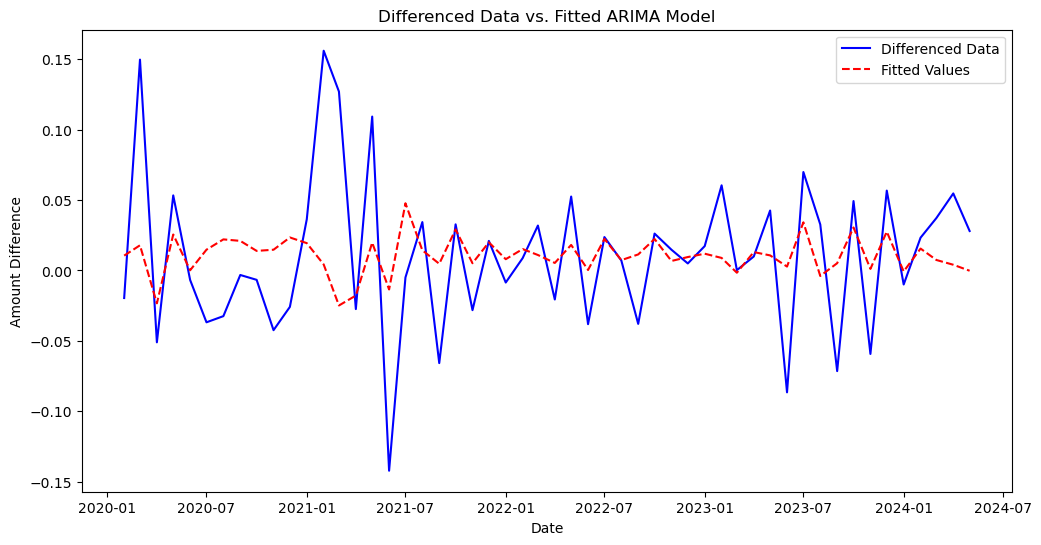

In [31]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(log_differenced.dropna(), order=(1, 0, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(log_differenced, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [32]:
# Align the fitted values with the original differenced data
aligned_index = log_differenced.index.intersection(fitted_values.index)
fitted_values_aligned = fitted_values.loc[aligned_index]
log_differenced_aligned = log_differenced.loc[aligned_index]

# Calculate residuals
residuals = log_differenced_aligned - fitted_values_aligned

# Compute MSE, RMSE, and MAE
mse = mean_squared_error(log_differenced_aligned, fitted_values_aligned)
rmse = np.sqrt(mse)
mae = mean_absolute_error(log_differenced_aligned, fitted_values_aligned)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 0.002856501051925785
RMSE: 0.053446244507222254
MAE: 0.03820845692424057


# Decomposed

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
decomposition = seasonal_decompose(monthly_sum['Amount'], model='additive', period=12)
trend = decomposition.trend.dropna()

# Remove trend
trend_removed = monthly_sum['Amount'] - trend
trend_removed = trend_removed.dropna()

# Check stationarity of the trend-removed data
check_stationarity2(trend_removed)


ADF Statistic: -5.01038084797435
p-value: 2.1166887327673262e-05
The time series is stationary.


In [34]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    trend_removed.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=944.630, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=957.356, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=949.247, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=951.944, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=945.961, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=952.968, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=942.449, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=943.099, Time=0.06 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=941.558, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=940.299, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=950.025, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=941.810, Time=0.0

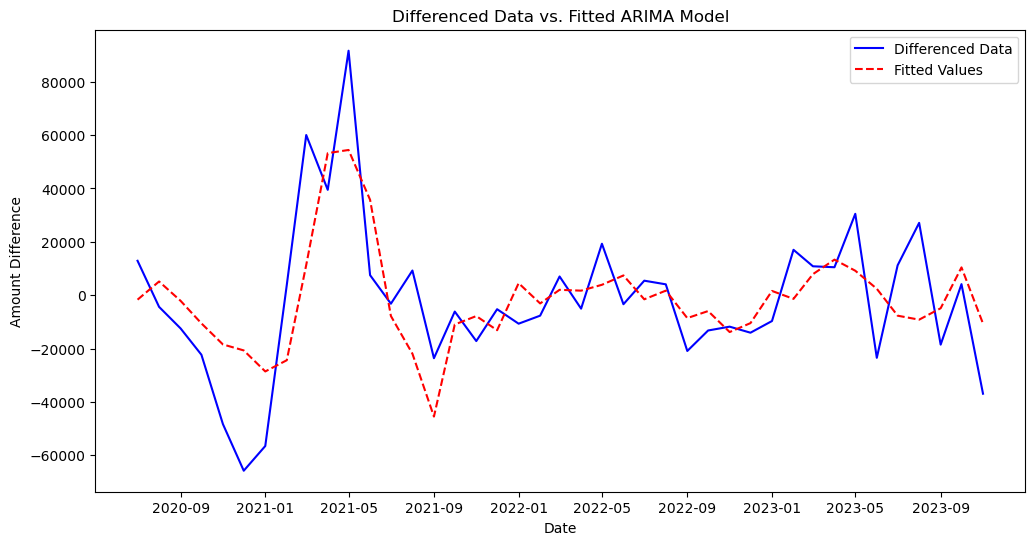

In [35]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(trend_removed.dropna(), order=(4, 0, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(trend_removed, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [36]:
# Align the fitted values with the original trend-removed data
aligned_index = trend_removed.index.intersection(fitted_values.index)
fitted_values_aligned = fitted_values.loc[aligned_index]
trend_removed_aligned = trend_removed.loc[aligned_index]

# Calculate residuals
residuals = trend_removed_aligned - fitted_values_aligned

# Compute MSE, RMSE, and MAE
mse = mean_squared_error(trend_removed_aligned, fitted_values_aligned)
rmse = np.sqrt(mse)
mae = mean_absolute_error(trend_removed_aligned, fitted_values_aligned)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 404241149.87608325
RMSE: 20105.74917470332
MAE: 16121.912711013058


# Reverting back to Original Data using the Decomposed Differencing

In [37]:
# Get the last known value from the original series
last_known_value = monthly_sum['Amount'].iloc[0]

# Reverse differencing for the fitted values
fitted_values_original_scale = pd.Series(
    last_known_value + fitted_values.cumsum(),
    index=monthly_sum.index[1:]  # Skip the first index which was used for initial amount
)

# Append NaN for the first index which was used for the initial amount
fitted_values_original_scale = pd.concat([
    pd.Series([last_known_value], index=[monthly_sum.index[0]]),
    fitted_values_original_scale
])


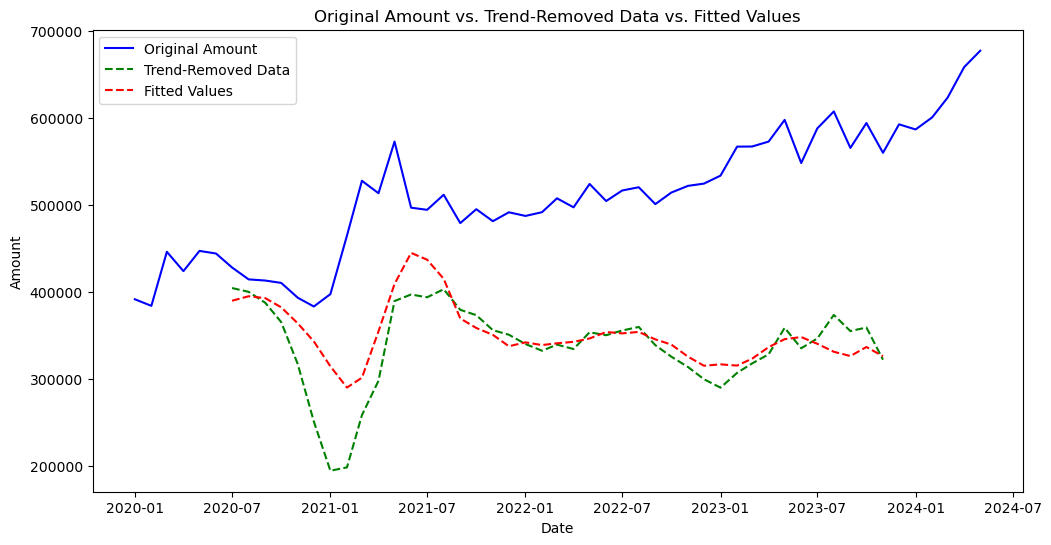

In [38]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(monthly_sum['Amount'], label='Original Amount', color='blue')

# Plot the reconstructed Amount from trend-removed data
plt.plot(trend_removed.cumsum() + last_known_value, label='Trend-Removed Data', color='green', linestyle='--')

# Plot the fitted values (reverted to original scale)
plt.plot(fitted_values_original_scale, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Original Amount vs. Trend-Removed Data vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()

# Show the plot
plt.show()


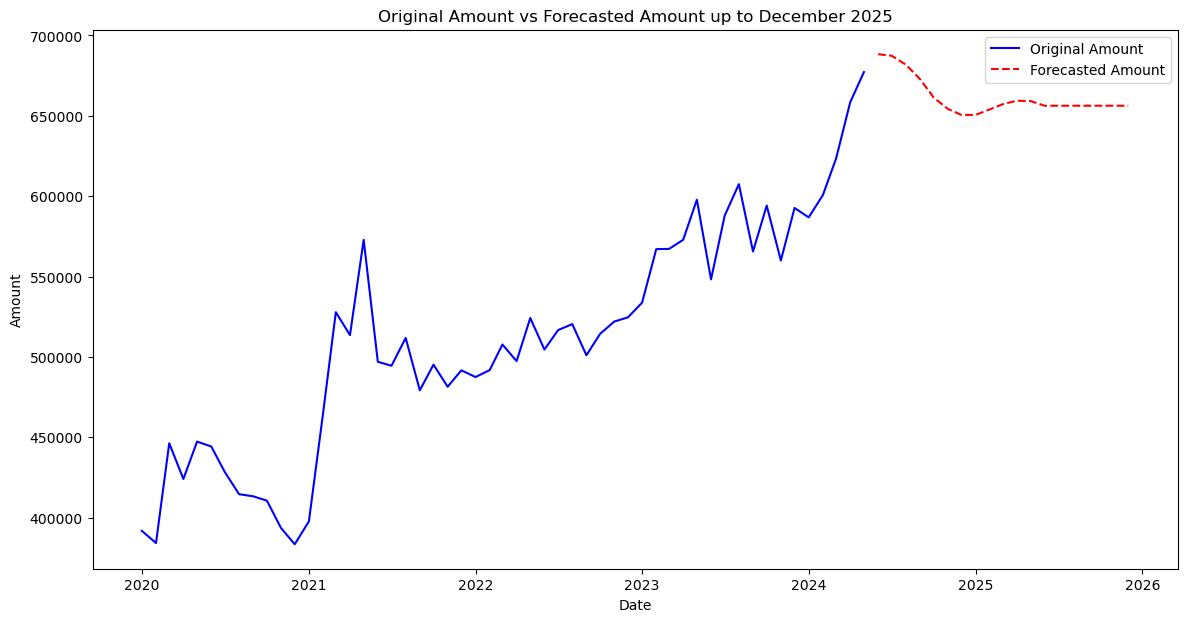

                 Forecast
2024-06-01  688291.464857
2024-07-01  687328.486840
2024-08-01  681770.246703
2024-09-01  672782.927826
2024-10-01  661282.546980
2024-11-01  654249.380314
2024-12-01  650461.882647
2025-01-01  650590.616360
2025-02-01  654012.039008
2025-03-01  657181.180556
2025-04-01  659371.425648
2025-05-01  659159.099606
2025-06-01  656255.481054
2025-07-01  656255.481054
2025-08-01  656255.481054
2025-09-01  656255.481054
2025-10-01  656255.481054
2025-11-01  656255.481054
2025-12-01  656255.481054


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['Amount'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['Amount'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])
